# Lane Following Autopilot with Keras & Tensorflow.
> Create a keras model that accepts images and outputs steering angles so that it can control a car and keep it between two white lines.

- toc: false 
- badges: false
- comments: false
- categories: [donkeycar, tensorflow, deeplearing, self driving] 
- image: images/copied_from_nb/donkeycar/lane_following.gif

This document walks through how to create a convolution neural network using Keras+Tensorflow and train it to keep a car between two white lines.

** Updated Feb 2, 2017 ** - Thanks to comments on Hacker News, I've updated this doc to use more machine learning best pratices.

Here is a Raspberry Pi controlled RC car using the autopilot crated in this document to drive between the lines. See [the donkey repository](https://github.com/wroscoe/donkey) for instructions to build your own car.

!['self driving rc car'](donkeycar/lane_following.gif)


In [1]:
import os
import urllib.request
import pickle

%matplotlib inline
import matplotlib
from matplotlib.pyplot import imshow

### Get the driving data
The dataset is composed of ~7900 images and steering angles collected as I manually drove the car. About 2/3 of the images are with the car between the lines. The other third is of the car starting off course and correcting by driving back to between the lines.  

In [2]:
#downlaod driving data (450Mb) 
data_url = 'https://s3.amazonaws.com/donkey_resources/indoor_lanes.pkl'
file_path, headers = urllib.request.urlretrieve(data_url)
print(file_path)

/tmp/tmpjjuhirpf


The dataset consists of 2 pickled arrays. X are the image arrays and Y is an array of the coresponding steering angles.

X.shape:  (7892, 120, 160, 3)
Y.shape:  (7892,)


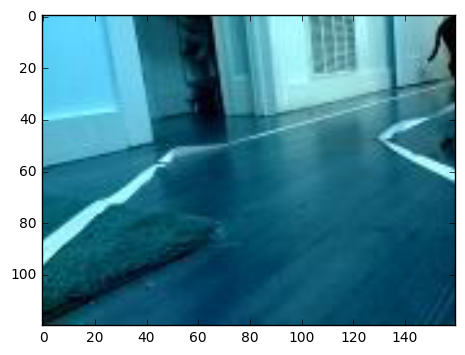

In [3]:
#extract data
with open(file_path, 'rb') as f:
    X, Y = pickle.load(f)
    
print('X.shape: ', X.shape)
print('Y.shape: ', Y.shape)
imshow(X[0])

### Split Data


Here we'll shuffle our data and separate the data into three parts. Training data will be used to train our driving model, Validation data is used avoid overfitting the model and Test data is used to test if our model learned anything.

In [4]:
import numpy as np

In [5]:
#shuffle  both X and Y the same way
def unison_shuffled_copies(X, Y):
    assert len(X) == len(Y)
    p = np.random.permutation(len(X))
    return X[p], Y[p]

shuffled_X, shuffled_Y = unison_shuffled_copies(X,Y)

len(shuffled_X)

7892

In [6]:
test_cutoff = int(len(X) * .8) # 80% of data used for training
val_cutoff = test_cutoff + int(len(X) * .1) # 10% of data used for validation and test data 

train_X, train_Y = shuffled_X[:test_cutoff], shuffled_Y[:test_cutoff]
val_X, val_Y = shuffled_X[test_cutoff:val_cutoff], shuffled_Y[test_cutoff:val_cutoff]
test_X, test_Y = shuffled_X[val_cutoff:], shuffled_Y[val_cutoff:]

len(train_X) + len(val_X) + len(test_X)

7892

### Augment Training Data
To double our training data and prevent steering bias, we flip each image and steering angle and add it to the dataset. There are [additional ways](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.725xwvqee) to augment driving data using translations and fake shadows but I didn't use those for this autopilot. 

In [7]:
X_flipped = np.array([np.fliplr(i) for i in train_X])
Y_flipped = np.array([-i for i in train_Y])
train_X = np.concatenate([train_X, X_flipped])
train_Y = np.concatenate([train_Y, Y_flipped])
len(train_X)

12626

### Build a driving model

This driving model will be an end-to-end neural network that accepts image arrays as input and outputs a steering angle between -90 (left) and 90 (right). To do this we'll use a 3 layer convolution network with one fully connected layer. This model is based off of [Otavio's Carputer](https://github.com/otaviogood/carputer/blob/master/NeuralNet/convnetshared1.py) but does not produce a throttle value output, does not use past steering values as input into the model, and uses one less convolution layer.

In [8]:
from keras.models import Model, load_model
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Dense


Using TensorFlow backend.


In [9]:
img_in = Input(shape=(120, 160, 3), name='img_in')
angle_in = Input(shape=(1,), name='angle_in')

x = Convolution2D(8, 3, 3)(img_in)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Convolution2D(16, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Convolution2D(32, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

merged = Flatten()(x)

x = Dense(256)(merged)
x = Activation('linear')(x)
x = Dropout(.2)(x)

angle_out = Dense(1, name='angle_out')(x)

model = Model(input=[img_in], output=[angle_out])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
img_in (InputLayer)              (None, 120, 160, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 118, 158, 8)   224         img_in[0][0]                     
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 118, 158, 8)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 59, 79, 8)     0           activation_1[0][0]               
___________________________________________________________________________________________

### Train the model. 
I've learned the hard way that even if everything to this point is perfect, your autopilot won't work if you don't train it correctly. The biggest problem I ran into was over fitting the model so that it would not work in evenlly slightly different scenarios. Here are 2 Keras callbacks that will save you time. 

**Warning - This will take a long time (3hrs) if only using a CPU**

I ran this notebook on my Dell XPS notebook that does not have a CUDA compatible GPU so it's very slow and freezes. To speed up training you can uses a EC2 instance with a GPU. Several instance images exist with Keras and Tensorflow already loaded. 

In [10]:
import os
from keras import callbacks

model_path = os.path.expanduser('~/best_autopilot.hdf5')

#Save the model after each epoch if the validation loss improved.
save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, 
                                     save_best_only=True, mode='min')

#stop training if the validation loss doesn't improve for 5 consecutive epochs.
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                                     verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]

For this notebook, I'll only train the model for 4 epochs.

In [11]:
model.fit(train_X, train_Y, batch_size=64, nb_epoch=4, validation_data=(val_X, val_Y), callbacks=callbacks_list)

Train on 12626 samples, validate on 789 samples
Epoch 1/4
12626/12626 [==============================] - 384s - loss: 822.5694 - val_loss: 516.5929
Epoch 2/4
12626/12626 [==============================] - 400s - loss: 430.4499 - val_loss: 384.8724
Epoch 3/4
12626/12626 [==============================] - 328s - loss: 348.1003 - val_loss: 321.2342
Epoch 4/4
12626/12626 [==============================] - 327s - loss: 304.4417 - val_loss: 326.8560


### Evaluate Performance
We  can check if our models predictions are reasonable by plotting the predictions vs the actual values. The first graph shows that there is a learned relationship in our test data (not seen by model during training). 

In [12]:
import pandas as pd

model = load_model(model_path)
test_P = model.predict(test_X)
test_P = test_P.reshape((test_P.shape[0],)) 

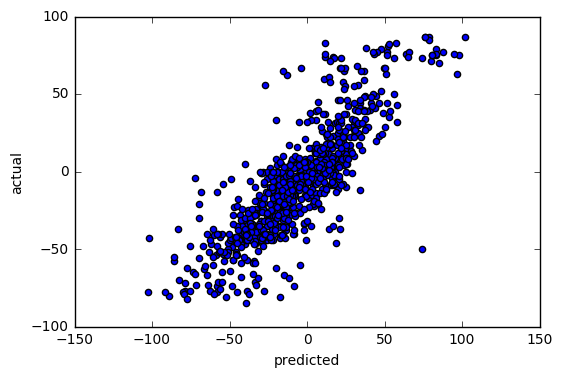

In [13]:
df = pd.DataFrame({'predicted':test_P, 'actual':test_Y})
ax = df.plot.scatter('predicted', 'actual')
#ax.set_ylabel("steering angle")

This second graph uses the unshuffled data that includes the training data to show the predicted angles closely follow the actual steering angles.

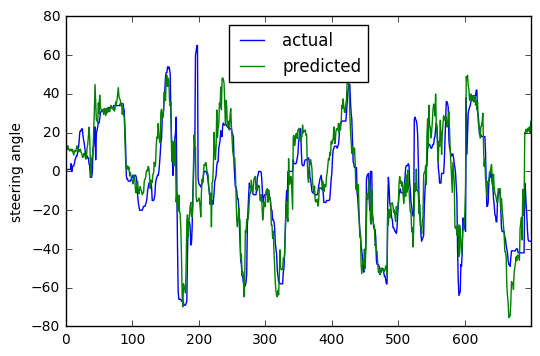

In [14]:
P = model.predict(X[:700])
#predict outputs nested arrays so we need to reshape to plot.
P = P.reshape((P.shape[0],)) 

ax = pd.DataFrame({'predicted':P, 'actual':Y[:700]}).plot()
ax.set_ylabel("steering angle")

## Next steps
* **Improve Model** This model is naive because it doesn't use past values to help predict the future. We could experiment with the model by feeding past steering angles as inputs to the model, add a recurrent layer, or just change the structure of the convolution layers. 
* **Add more data** This model will improve as we add more driving data. 
* **Predict throttle outputs** Currently the autopilot only steers and maintains a constant speed. A more sophisticated model would speed up on straightaways and slow down before curbs.
